<a href="https://colab.research.google.com/github/robinmamie/cs-433-projects/blob/master/unet_try_jeremy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://androidkt.com/tensorflow-keras-unet-for-image-image-segmentation/

https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

https://arxiv.org/pdf/1505.04597.pdf


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Required folder structure

A folder name ```ML_road_image``` wich contains the following subfolders:
* ```groundtruth```
* ```images```
* ```predictions_submission```
* ```test_set_images```

this folder also contains 2 files:
* ```road_segmentation_model.h5``` Saved version the model. Allows to recuperate the weights of the previous training that was done
* ```smooth_tiled_prediction.py``` This will automatically get fetched if not present.

In another folder we will store the autogenerated images. This folder should be called ```ML_road_images_1200```. It was initially called like this becuase it contained 1200 images. This number is variable and the same is stupid.
In this folder there must be 2 subfolders:
* ```groundtruth```
* ```images```

In [45]:
import tensorflow as tf
import os
import sys
 
import numpy as np
 
from tqdm import tqdm
from itertools import chain
 
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt
!pip install tensorboardcolab

PATH_TO_SMOOTH_TILED_PREDICT = 'drive/My Drive/ML_road_image/'
sys.path.insert(1, PATH_TO_SMOOTH_TILED_PREDICT)

exists = os.path.isfile("drive/My Drive/ML_road_image/smooth_tiled_predictions.py")
if not exists:
  print("[INFO]: Downloading smooth tile prediction")
  !wget --output-document=drive/My\ Drive/ML_road_image/smooth_tiled_predictions.py https://raw.githubusercontent.com/Vooban/Smoothly-Blend-Image-Patches/master/smooth_tiled_predictions.py
from smooth_tiled_predictions import predict_img_with_smooth_windowing

[INFO]: Downloading smooth tile prediction
--2019-12-06 13:39:13--  https://raw.githubusercontent.com/Vooban/Smoothly-Blend-Image-Patches/master/smooth_tiled_predictions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14986 (15K) [text/plain]
Saving to: ‘drive/My Drive/ML_road_image/smooth_tiled_predictions.py’

drive/My Drive/ML_r 100%[===================>]  14.63K  --.-KB/s    in 0.01s   

2019-12-06 13:39:14 (1.15 MB/s) - ‘drive/My Drive/ML_road_image/smooth_tiled_predictions.py’ saved [14986/14986]



In [2]:
# from https://gist.github.com/okomarov/c0d9fd0718f6f9b40c701e61523dfed1

!pip install gputil
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.6 GB  | Proc size: 377.1 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
IMG_WIDTH = 400
IMG_HEIGHT = 400
IMG_CHANNELS = 3
 
IMAGE_DATA_PATH = 'drive/My Drive/ML_road_image/images/'
MASK_DATA_PATH = 'drive/My Drive/ML_road_image/groundtruth/'
MODEL_SAVE_LOCATION = 'drive/My Drive/ML_road_image/road_segmentation_model.h5'
USE_SAVED_MODEL = True



In [0]:
images_filenames = os.listdir(IMAGE_DATA_PATH)

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import argparse


GENERATE_NEW_IMG = False
USE_GENERATED_IMG = False
OUTPUT_DATA_IMAGE_PATH = 'drive/My Drive/ML_road_image_1200/'
IMG_TO_GEN_PER_IMG = 15

if GENERATE_NEW_IMG:
  # load the input image, convert it to a NumPy array, and then
  # reshape it to have an extra dimension
  for img in tqdm(images_filenames):
      image = load_img(IMAGE_DATA_PATH+img)
      image = img_to_array(image)
      image = np.expand_dims(image, axis=0)

      truth = load_img(MASK_DATA_PATH+img)
      truth = img_to_array(truth)
      truth = np.expand_dims(truth, axis=0)
      # construct the image generator for data augmentation then
      # initialize the total number of images generated thus far
      aug = ImageDataGenerator(
          rotation_range=15,
          zoom_range=0.15,
          brightness_range=[0.7,1],
          width_shift_range=0.1,
          height_shift_range=0.1,
          vertical_flip=True,
          shear_range=0.15,
          horizontal_flip=True,
          fill_mode="reflect")
      total = 0

      # construct the actual Python generator
      imageGen = aug.flow(image, y=truth, batch_size=1, save_to_dir=OUTPUT_DATA_IMAGE_PATH + "images",
          save_prefix=img.split(".")[0], save_format="png", seed = 2 )
      truthGen = aug.flow(truth, y=truth, batch_size=1, save_to_dir=OUTPUT_DATA_IMAGE_PATH + "groundtruth",
          save_prefix=img.split(".")[0], save_format="png", seed = 2 )
      # loop over examples from our image data augmentation generator
      for image in imageGen:
          # increment our counter
          total += 1

          # if we have reached the specified number of examples, break
          # from the loop
          if total == IMG_TO_GEN_PER_IMG:
              break
              
      total = 0
      for image in truthGen:
          # increment our counter
          total += 1

          # if we have reached the specified number of examples, break
          # from the loop
          if total == IMG_TO_GEN_PER_IMG:
              break

if(USE_GENERATED_IMG):
  print("[INFO]: Updating images_filename")
  IMAGE_DATA_PATH = OUTPUT_DATA_IMAGE_PATH+'images/'
  MASK_DATA_PATH = OUTPUT_DATA_IMAGE_PATH+ 'groundtruth/'
  print("[INFO]: new MASK_DATA_PATH : "+ MASK_DATA_PATH)
  print("[INFO]: new IMAGE_DATA_PATH : " + IMAGE_DATA_PATH)
  images_filenames = os.listdir(IMAGE_DATA_PATH)
  print("[INFO]: There are " + str(len(images_filenames)) + " found")
S = 42
random.seed = S
np.random.seed = S

Using TensorFlow backend.


In [6]:
print("[INFO]: Loading images into RAM", flush = True)
X = np.zeros((len(images_filenames), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(images_filenames), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, filename in tqdm(enumerate(images_filenames), total=len(images_filenames)):   
    img = imread(IMAGE_DATA_PATH + filename)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = imread(MASK_DATA_PATH + filename)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
    if USE_GENERATED_IMG:
      Y[n] = mask[:,:,0]
    else:
      Y[n] = mask
 
x_train=X 
y_train=Y

[INFO]: Loading images into RAM


100%|██████████| 100/100 [00:05<00:00, 19.79it/s]


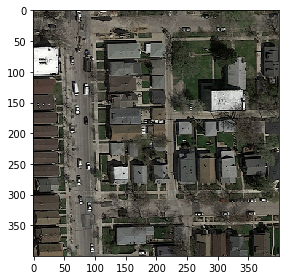

In [7]:
imshow(x_train[1])

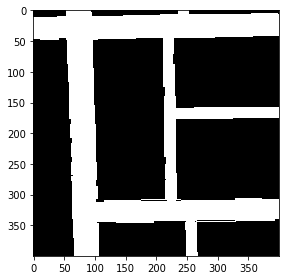

In [8]:
imshow(np.squeeze(y_train[1]))

In [9]:
'''
#TPU
#https://medium.com/analytics-vidhya/tpu-training-made-easy-with-colab-3b73b920878f


# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError: # If TPU not found
  tpu = None

# Select appropriate distribution strategy
if tpu:
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
  strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
  print('Running on CPU instead')
print("Number of accelerators: ", strategy.num_replicas_in_sync)
'''

'\n#TPU\n#https://medium.com/analytics-vidhya/tpu-training-made-easy-with-colab-3b73b920878f\n\n\n# Detect hardware\ntry:\n  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection\nexcept ValueError: # If TPU not found\n  tpu = None\n\n# Select appropriate distribution strategy\nif tpu:\n  tf.tpu.experimental.initialize_tpu_system(tpu)\n  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128)\n  print(\'Running on TPU \', tpu.cluster_spec().as_dict()[\'worker\'])  \nelse:\n  strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU\n  print(\'Running on CPU instead\')\nprint("Number of accelerators: ", strategy.num_replicas_in_sync)\n'

In [10]:
# Build U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH,+ IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)
 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 400, 400, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout) 

In [11]:
if USE_SAVED_MODEL:
  if not os.path.isfile(MODEL_SAVE_LOCATION):
    print("[ERROR]: Could not locate file for model weights. Proceding without loading weights.")
  else:
    model.load_weights(MODEL_SAVE_LOCATION)
    print("[INFO]: Loading saved model weights")

[INFO]: Loading saved model weights


In [0]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
# Create checkpoint callback

%load_ext tensorboard
import datetime
!rm -rf ./logs/ 
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [
  #tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  #tensorboard_callback,
  cp_callback 
]
#%tensorboard --logdir logs/fit


In [13]:
printm()

Gen RAM Free: 12.1 GB  | Proc size: 1.1 GB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [111]:
 %%time

 x_train = X
 y_train = Y
 results = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=10,
                    callbacks=callbacks)
 
 model.save_weights(MODEL_SAVE_LOCATION, overwrite=True)

Train on 90 samples, validate on 10 samples
Epoch 1/10
80/90 [=========================>....] - ETA: 0s - loss: 0.0232 - acc: 0.9893

KeyboardInterrupt: ignored

In [0]:
 #https://github.com/kiteco/kite-python-blog-post-code/blob/master/image-segmentation/image_segmentation.py

"""
Helper functions used to estimate F1 score.
"""
import sklearn.metrics
def get_f1_score(groundtruth_list, predicted_list):
    """Return f1 score covering edge cases"""

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    if _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        f1_score = 1
    elif _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        f1_score = 1
    else:
        f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score
def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
	See example code for helper function definitions
    """
    _assert_valid_lists(groundtruth_list, predicted_list)

    if _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        tn, fp, fn, tp = 0, 0, 0, np.float64(len(groundtruth_list))

    elif _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        tn, fp, fn, tp = np.float64(len(groundtruth_list)), 0, 0, 0

    else:
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth_list, predicted_list).ravel()
        tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp

def _assert_valid_lists(groundtruth_list, predicted_list):
    assert len(groundtruth_list) == len(predicted_list)
    for unique_element in np.unique(groundtruth_list).tolist():
        assert unique_element in [0, 1]

def _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == np.unique(predicted_list).tolist() == [1]


def _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == np.unique(predicted_list).tolist() == [0]



In [19]:
print("[INFO]: Estimating F1 score", flush=True)
import numpy as np
print(np.__version__)
F1_accumulator = 0
NUMBER_OF_IMG_TO_TEST = 10
for idx in tqdm(range(NUMBER_OF_IMG_TO_TEST)):
  x=np.array(x_train[idx])
  x=np.expand_dims(x, axis=0)
  predict = model.predict(x, verbose=0)
  
  predict = (predict > 0.5).astype(np.uint8)
  f1 = get_f1_score(y_train[idx].flatten(),predict[0].flatten())
  F1_accumulator += f1
  #print("F1: "+ str(f1))
print("\nAverage F1: " + str(F1_accumulator / NUMBER_OF_IMG_TO_TEST))

[INFO]: Estimating F1 score


  0%|          | 0/10 [00:00<?, ?it/s]

1.17.4


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Average F1: 0.9840959871259047


1/1 [==============================] - 0s 28ms/sample


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


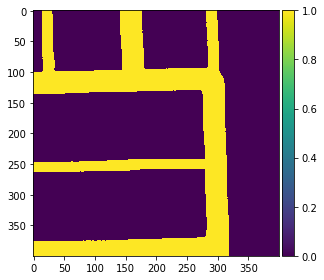

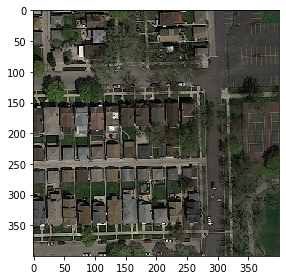

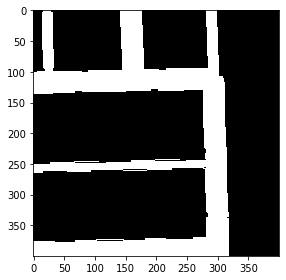

In [21]:

idx = random.randint(0, len(x_train)-1)
x=np.array(x_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)
 
predict = (predict > 0.5).astype(np.uint8)
 
imshow(np.squeeze(predict[0]))
plt.show()
 
imshow(x_train[idx])
 
plt.show()
imshow(np.squeeze(y_train[idx]))

In [0]:
def get_prediction(img):
    x=np.array(img)
    x=np.expand_dims(x, axis=0)
    predict = model.predict(x, verbose=1)
    print(predict.shape)
    predict = (predict > 0.5).astype(np.uint8)
    predict = np.squeeze(predict[0])
    print(predict.shape)

    return predict

1/1 [==============================] - 0s 29ms/sample
(1, 400, 400, 1)
(400, 400)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


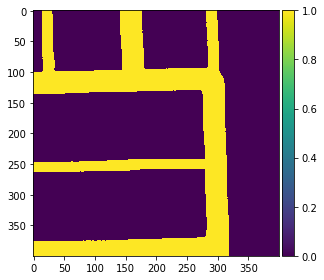

In [27]:
imshow(get_prediction(x_train[4]))

In [0]:
from PIL import Image

In [0]:
PIXEL_DEPTH=255
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)
    return rimg

In [0]:
submission_data_dir = 'drive/My Drive/ML_road_image/test_set_images/'
prediction_submission_dir = "drive/My Drive/ML_road_image/predictions_submission/"

In [34]:
RUM_PREDICTIONS_ON_TEST_IMAGES = False
submission_data_dir = 'drive/My Drive/ML_road_image/test_set_images/'
prediction_submission_dir = "drive/My Drive/ML_road_image/predictions_submission/"

predictions = []

if RUM_PREDICTIONS_ON_TEST_IMAGES:
  print("[INFO]: Running prediction on submission set")
  if not os.path.isdir(prediction_submission_dir):
      os.mkdir(prediction_submission_dir)
  for i in range(1, 51):
      pimg = imread(submission_data_dir + f"test_{i}/test_{i}.png")[:,:,:IMG_CHANNELS]
      predictions.append(predict_img_with_smooth_windowing(
        pimg,
        window_size=window_size,
        subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
        nb_classes=nb_classes,
        pred_func=(
            lambda img_batch_subdiv: model.predict(img_batch_subdiv)
        )
      ))
else:
  print("[INFO]: Skipping predicting test images")

[INFO]: Skipping predicting test images


In [35]:
if RUM_PREDICTIONS_ON_TEST_IMAGES:
  print("[INFO]: Writting prediction to drive")

  ROAD_THRESHOLD = 0.1

  pred = np.array(predictions.copy())
  for i in range(1, 51):
    pimg = pred[i-1]
    w = pimg.shape[0]
    h = pimg.shape[1]
    cimg = np.zeros((w, h, 3), dtype=np.uint8)
    pimg = (pimg > ROAD_THRESHOLD).astype(np.uint8)
    pimg8 = np.squeeze(img_float_to_uint8(pimg))
    cimg[:, :, 0] = pimg8
    cimg[:, :, 1] = pimg8
    cimg[:, :, 2] = pimg8
    Image.fromarray(cimg).save(prediction_submission_dir + f"gt_{i}.png")
else:
  print("[INFO]: Skipping write of predictions to disk")

[INFO]: Skipping write of predictions to disk


In [36]:
# From: https://github.com/Vooban/Smoothly-Blend-Image-Patches

# CNN's receptive field's border size: size of patches
window_size = 400

# Amount of categories predicted per pixels.
nb_classes = 1

# Load an image. Convention is channel_last, such as having an input_img.shape of: (x, y, nb_channels), where nb_channels is of 3 for regular RGB images.
i = 30
input_img = imread(submission_data_dir + f"test_{i}/test_{i}.png")[:,:,:IMG_CHANNELS]

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=window_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=nb_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict(img_batch_subdiv)
    )
)

100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


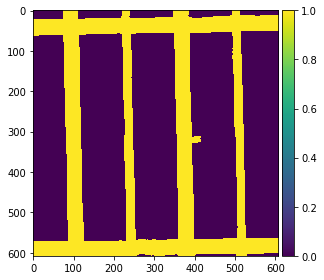

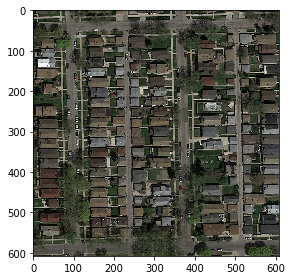

In [38]:
predict = (predictions_smooth > ROAD_THRESHOLD).astype(np.uint8)

imshow(np.squeeze(predict))
plt.show()
imshow(input_img)

In [92]:
# creating ouput for submission

import os
import numpy as np
import matplotlib.image as mpimg
import re
from time import strftime

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


time = strftime("%Y%m%dT%H%M%S")
submission_filename = f'submission-{time}.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = f'{prediction_submission_dir}gt_{i}.png'
    print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)

drive/My Drive/ML_road_image/predictions_submission/gt_1.png
drive/My Drive/ML_road_image/predictions_submission/gt_2.png
drive/My Drive/ML_road_image/predictions_submission/gt_3.png
drive/My Drive/ML_road_image/predictions_submission/gt_4.png
drive/My Drive/ML_road_image/predictions_submission/gt_5.png
drive/My Drive/ML_road_image/predictions_submission/gt_6.png
drive/My Drive/ML_road_image/predictions_submission/gt_7.png
drive/My Drive/ML_road_image/predictions_submission/gt_8.png
drive/My Drive/ML_road_image/predictions_submission/gt_9.png
drive/My Drive/ML_road_image/predictions_submission/gt_10.png
drive/My Drive/ML_road_image/predictions_submission/gt_11.png
drive/My Drive/ML_road_image/predictions_submission/gt_12.png
drive/My Drive/ML_road_image/predictions_submission/gt_13.png
drive/My Drive/ML_road_image/predictions_submission/gt_14.png
drive/My Drive/ML_road_image/predictions_submission/gt_15.png
drive/My Drive/ML_road_image/predictions_submission/gt_16.png
drive/My Drive/ML